### Introduction

The FAA, Federal Aviation Authority of the United States, is looking to improve air transportation efficiency across the United States. They have hired my team of data scientists to utilize data from 2015 Flight Delays and Cancellations to build a model that can predict whether a flight will be delayed or not. The FAA aims to use the results of this model to strategize how flights across the United States can run more smoothly; whether that be that specific airlines need to implement ways to improve timeliness, if specific airports are experiencing more delays than others, or whether some conditions are outside of the FAA's control (i.e. weather delays in Chicago or other areas with harsher winter climates that experience many delays due to snow in December). Having a model that can predict whether a flight is delayed or not can help the FAA determine how to allocate resources effectively in order to prevent flight delays in the United States as much as possible. 

I will begin this project by importing all of the necessary libraries and an exploratory data analysis. Overall, the goal of this project is to identify which machine learning model is best able to predict the likelihood that a flight will be delayed, using data from 2015 Flights and Cancellations. I will use a variety of machine learning models and tune them accordingly in order to optimize performance metrics for this model. 

### Data Cleaning

In [1]:
#Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

In [2]:
#create dataframe 
df = pd.read_csv('travel_data.csv')
df = df.drop(['Unnamed: 0'], axis=1)

In [3]:
#Investigate the shape of the data
df.shape

(10000, 39)

In [4]:
#Preview the first 5 rows of the dataset 
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT_CODE,DESTINATION_AIRPORT_CODE,SCHEDULED_DEPARTURE,...,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,AIRPORT_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,2015,1,28,3,WN,103,N7728D,DCA,MKE,705,...,NaN,NaN,Southwest Airlines Co.,DCA,Ronald Reagan Washington National Airport,Arlington,VA,USA,38.85208,-77.03772
1,2015,8,11,2,B6,153,N592JB,JFK,PBI,1859,...,255.0,0.0,JetBlue Airways,JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893
2,2015,2,4,3,DL,1187,N921DN,MSP,DCA,1735,...,NaN,NaN,Delta Air Lines Inc.,MSP,Minneapolis-Saint Paul International Airport,Minneapolis,MN,USA,44.88055,-93.21692
3,2015,3,27,5,WN,171,N407WN,DEN,RDU,1815,...,NaN,NaN,Southwest Airlines Co.,DEN,Denver International Airport,Denver,CO,USA,39.85841,-104.66700
4,2015,8,1,6,WN,4330,N7751A,ATL,RIC,2125,...,NaN,NaN,Southwest Airlines Co.,ATL,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,USA,33.64044,-84.42694


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 39 columns):
YEAR                        10000 non-null int64
MONTH                       10000 non-null int64
DAY                         10000 non-null int64
DAY_OF_WEEK                 10000 non-null int64
AIRLINE_CODE                10000 non-null object
FLIGHT_NUMBER               10000 non-null int64
TAIL_NUMBER                 9962 non-null object
ORIGIN_AIRPORT_CODE         10000 non-null object
DESTINATION_AIRPORT_CODE    10000 non-null object
SCHEDULED_DEPARTURE         10000 non-null int64
DEPARTURE_TIME              9821 non-null float64
DEPARTURE_DELAY             9821 non-null float64
TAXI_OUT                    9818 non-null float64
WHEELS_OFF                  9818 non-null float64
SCHEDULED_TIME              10000 non-null float64
ELAPSED_TIME                9793 non-null float64
AIR_TIME                    9793 non-null float64
DISTANCE                    10000 non-null int64

Before we begin any data cleaning or transformations, let's take a look at the distribution of our variables. 

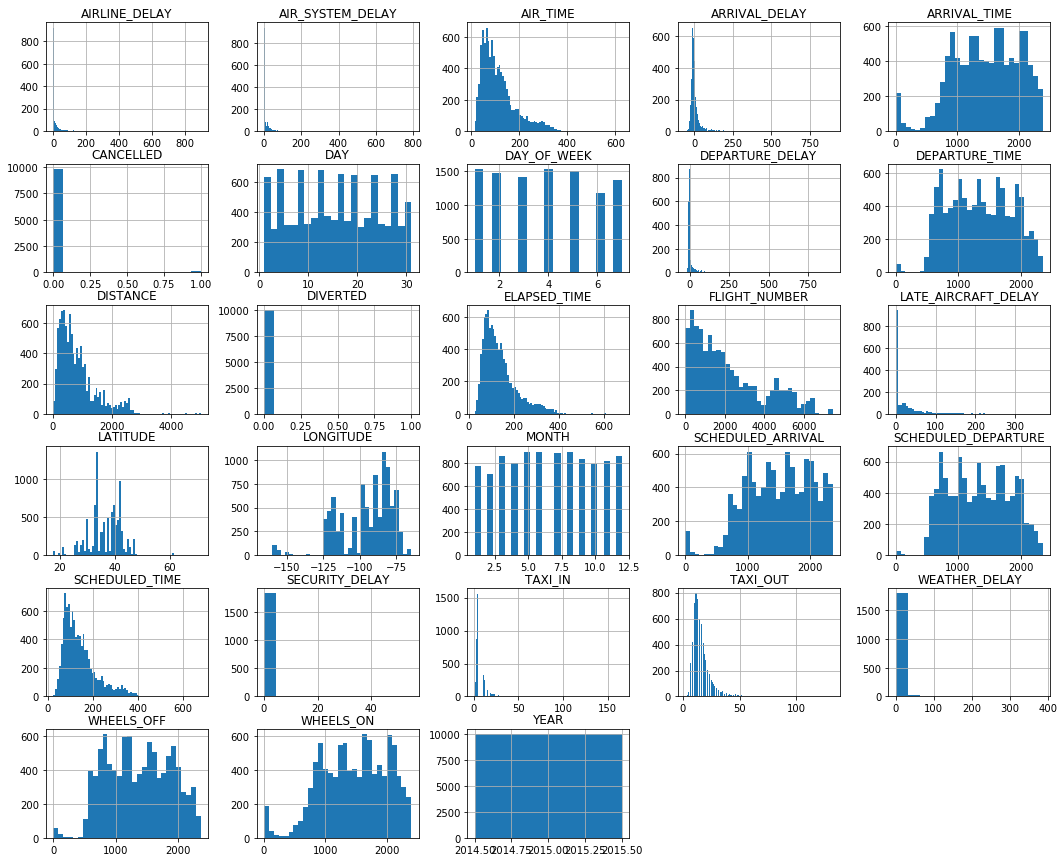

In [6]:
#First, let's plot a histogram for each column
df.hist(figsize=(18,15), bins='auto');

Our analysis is looking at whether a departure delay is impacted by the month, day, airline or airport. 

Therefore, certain variables at this point can be dropped; firstly, anything involved in the delayed/cancellation reason can be removed. Next, we can remove "year" as this dataset only contains values from 2015. Other irrelevant variables in this context are flight number, tail number, departure time, taxi in, taxi out, wheels off, wheels on, and so on, and we will remove all of those unnecessary values below.

In [7]:
#Remove all columns not related to this analysis
df = df.drop(['YEAR', 'FLIGHT_NUMBER', 'DEPARTURE_TIME', 'TAXI_IN', 'TAXI_OUT', 
              'WHEELS_OFF', 'WHEELS_ON', 'ELAPSED_TIME', 'AIR_TIME', 'ARRIVAL_TIME', 
              'DIVERTED', 'CANCELLED', 'TAIL_NUMBER', 'CANCELLATION_REASON', 
              'LATITUDE', 'LONGITUDE', 'AIRPORT', 'DAY'], axis=1)

In [8]:
#Display some sample statistics and look for outliers 

desc_df = df.describe()

#add std metric at the bottom to look for outliers that 3 stds away from the mean
desc_df.loc['+3_std'] = desc_df.loc['mean'] + (desc_df.loc['std'] * 3)
desc_df.loc['-3_std'] = desc_df.loc['mean'] - (desc_df.loc['std'] * 3)

desc_df

,MONTH,DAY_OF_WEEK,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,10000.000000,10000.000000,10000.000000,9821.000000,10000.000000,10000.000000,10000.000000,9793.000000,1839.000000,1839.000000,1839.000000,1839.000000,1839.000000
mean,6.583000,3.906200,1335.638800,9.913756,142.183500,827.452200,1498.106300,5.012866,15.040239,0.077760,20.052746,24.172920,2.486678
std,3.390378,1.989220,488.881087,39.893034,75.455193,613.444234,516.702029,42.232465,36.098802,1.622388,54.761039,42.934592,18.060854
min,1.000000,1.000000,5.000000,-27.000000,24.000000,31.000000,2.000000,-59.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,2.000000,918.750000,-5.000000,86.000000,373.000000,1106.000000,-13.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,4.000000,1330.000000,-2.000000,123.000000,649.000000,1524.500000,-5.000000,2.000000,0.000000,2.000000,3.000000,0.000000
75%,9.000000,6.000000,1740.000000,7.000000,174.000000,1066.000000,1925.250000,8.000000,18.000000,0.000000,18.000000,31.000000,0.000000
max,12.000000,7.000000,2359.000000,904.000000,680.000000,4983.000000,2359.000000,898.000000,791.000000,55.000000,898.000000,370.000000,388.000000
+3_std,16.754133,9.873861,2802.282062,129.592859,368.549080,2667.784903,3048.212388,131.710262,123.336646,4.944925,184.335864,152.976697,56.669241
-3_std,-3.588133,-2.061461,-131.004462,-109.765346,-84.182080,-1012.880503,-51.999788,-121.684530,-93.256167,-4.789405,-144.230372,-104.630857,-51.695886


Before we continue, I will need to deal with null values in my dataset. For columns where the string information is unknown, such as airport code, city, state, etc, we will replace these values with 0. For values involving departure and arrival delays, we will fill the NaN values with the columns' median.

In [9]:
#Exploring null values 
df.isna().sum()

MONTH                          0
DAY_OF_WEEK                    0
AIRLINE_CODE                   0
ORIGIN_AIRPORT_CODE            0
DESTINATION_AIRPORT_CODE       0
SCHEDULED_DEPARTURE            0
DEPARTURE_DELAY              179
SCHEDULED_TIME                 0
DISTANCE                       0
SCHEDULED_ARRIVAL              0
ARRIVAL_DELAY                207
AIR_SYSTEM_DELAY            8161
SECURITY_DELAY              8161
AIRLINE_DELAY               8161
LATE_AIRCRAFT_DELAY         8161
WEATHER_DELAY               8161
AIRLINE                        0
AIRPORT_CODE                 790
CITY                         790
STATE                        790
COUNTRY                      790
dtype: int64

In [10]:
#Replace null values with blanks for these string columns where the information is unknown 

# df = df.replace("nan","0")

col = ['AIRPORT_CODE','CITY', 'STATE', 'COUNTRY', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY' ]

for name in col:
    df[name] = df[name].fillna(value=0)

In [11]:
#See if any null values are remaining 
df.isna().sum()

MONTH                         0
DAY_OF_WEEK                   0
AIRLINE_CODE                  0
ORIGIN_AIRPORT_CODE           0
DESTINATION_AIRPORT_CODE      0
SCHEDULED_DEPARTURE           0
DEPARTURE_DELAY             179
SCHEDULED_TIME                0
DISTANCE                      0
SCHEDULED_ARRIVAL             0
ARRIVAL_DELAY               207
AIR_SYSTEM_DELAY              0
SECURITY_DELAY                0
AIRLINE_DELAY                 0
LATE_AIRCRAFT_DELAY           0
WEATHER_DELAY                 0
AIRLINE                       0
AIRPORT_CODE                  0
CITY                          0
STATE                         0
COUNTRY                       0
dtype: int64

In [12]:
#For unknown variables involving time, replace nans with median values 
#Median values were used instead of mean values as potential outliers (i.e. longer air time, extreme departure 
#delays etc) will have a stronger influence on the mean than the median

col2 = ['DEPARTURE_DELAY', 'ARRIVAL_DELAY']

for value in col2:
    df[value].fillna(df[value].median(), inplace=True)

In [13]:
#Check for any remaining null values 
df.isna().sum()

MONTH                       0
DAY_OF_WEEK                 0
AIRLINE_CODE                0
ORIGIN_AIRPORT_CODE         0
DESTINATION_AIRPORT_CODE    0
SCHEDULED_DEPARTURE         0
DEPARTURE_DELAY             0
SCHEDULED_TIME              0
DISTANCE                    0
SCHEDULED_ARRIVAL           0
ARRIVAL_DELAY               0
AIR_SYSTEM_DELAY            0
SECURITY_DELAY              0
AIRLINE_DELAY               0
LATE_AIRCRAFT_DELAY         0
WEATHER_DELAY               0
AIRLINE                     0
AIRPORT_CODE                0
CITY                        0
STATE                       0
COUNTRY                     0
dtype: int64

The next step of our EDA will be to determine if there are any outliers in our dataset and decide if they need to be removed or not.

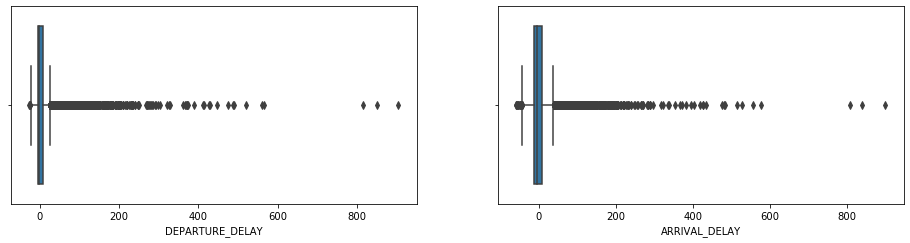

In [14]:
#Create boxplots to identify outliers
plt.figure(figsize=(16,8))
plt.subplot(221)
sns.boxplot(x=df['DEPARTURE_DELAY'])
plt.subplot(222)
sns.boxplot(x=df['ARRIVAL_DELAY'])

As we see from the boxplots above, there are several outliers in both departure and arrival delays. In our dataset there are clearly some extreme examples where arrivals and departures were severly delayed, likely due to extentuating, unusual circumstances. For now we will leave the data as is in order to explore it further, however we may consider dropping these outliers later on. 

In [15]:
#Find the number of unique origin and destination airport codes 
print(df['ORIGIN_AIRPORT_CODE'].nunique())
print(df['DESTINATION_AIRPORT_CODE'].nunique())

411
409


As there are so many airports in our dataset, let's take a look at the top 10 airports with the most frequent amount of flights.

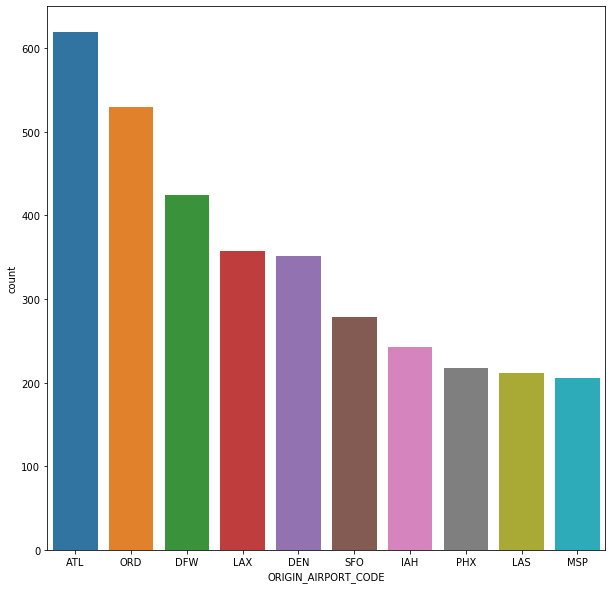

In [16]:
#Build histogram to find the airports with the most flight traffic 
plt.figure(figsize=(10, 10))
axis = sns.countplot(x=df['ORIGIN_AIRPORT_CODE'], data = df,
              order=df['ORIGIN_AIRPORT_CODE'].value_counts().iloc[:10].index)
axis.set_xticklabels(axis.get_xticklabels())

plt.show()

Atlanta, Chicago and Dallas appear to be the top 3 busiest airports. This makes sense, as they are hubs for Delta, United and American Airlines, respectively. 

In [17]:
#We see below that several airports only appear once in the dataset 
df['ORIGIN_AIRPORT_CODE'].value_counts(ascending=True)

11986      1
PSG        1
GCK        1
SWF        1
14574      1
        ... 
DEN      351
LAX      357
DFW      424
ORD      529
ATL      619
Name: ORIGIN_AIRPORT_CODE, Length: 411, dtype: int64

As we see above, there are over 400 airports in our dataset. Additionally, some of the listed airports only appear once; actually, more than 50% of our data appears rather infrequently. Before we one-hot-encode this column, it makes sense to bin this variable.

I have chosen to bin this variable based on whether the origin of the airport is an airport with heavy, medium light, or very light air traffic (i.e. if the airport appears very frequently in the dataset then this is an airport with high traffic, somewhat frequently then medium, etc. 

In [18]:
#Create new variable "origin_airport_type" based on the quantile for their number of flights 
bins_97 = df['ORIGIN_AIRPORT_CODE'].value_counts().quantile(0.97)
bins_90 = df['ORIGIN_AIRPORT_CODE'].value_counts().quantile(0.90)
bins_77 = df['ORIGIN_AIRPORT_CODE'].value_counts().quantile(0.77)

airports = df['ORIGIN_AIRPORT_CODE'].value_counts()
airports_index = df[df['ORIGIN_AIRPORT_CODE'].isin(airports[airports > bins_97].index)].index
df.loc[airports_index,'ORIGIN_AIRPORT_TYPE'] = 'High'

airports_index = df[df['ORIGIN_AIRPORT_CODE'].isin(airports[(airports > bins_90)&(airports <= bins_97)].index)].index
df.loc[airports_index,'ORIGIN_AIRPORT_TYPE'] = 'Medium'

airports_index = df[df['ORIGIN_AIRPORT_CODE'].isin(airports[(airports > bins_77)&(airports <= bins_90)].index)].index
df.loc[airports_index,'ORIGIN_AIRPORT_TYPE'] = 'Low'

airports_index = df[df['ORIGIN_AIRPORT_CODE'].isin(airports[airports <= bins_77].index)].index
df.loc[airports_index,'ORIGIN_AIRPORT_TYPE'] = 'Very Low'

In [19]:
#see the distribution of this new variable 
df['ORIGIN_AIRPORT_TYPE'].value_counts()

High        4003
Medium      3073
Low         1554
Very Low    1370
Name: ORIGIN_AIRPORT_TYPE, dtype: int64

In [20]:
#Repeat this same binning process for the destination airports 
bins_97 = df['DESTINATION_AIRPORT_CODE'].value_counts().quantile(0.97)
bins_90 = df['DESTINATION_AIRPORT_CODE'].value_counts().quantile(0.90)
bins_77 = df['DESTINATION_AIRPORT_CODE'].value_counts().quantile(0.77)

airports = df['DESTINATION_AIRPORT_CODE'].value_counts()
airports_index = df[df['DESTINATION_AIRPORT_CODE'].isin(airports[airports > bins_97].index)].index
df.loc[airports_index,'DESTINATION_AIRPORT_TYPE'] = 'High'

airports_index = df[df['DESTINATION_AIRPORT_CODE'].isin(airports[(airports > bins_90)&(airports <= bins_97)].index)].index
df.loc[airports_index,'DESTINATION_AIRPORT_TYPE'] = 'Medium'

airports_index = df[df['DESTINATION_AIRPORT_CODE'].isin(airports[(airports > bins_77)&(airports <= bins_90)].index)].index
df.loc[airports_index,'DESTINATION_AIRPORT_TYPE'] = 'Low'

airports_index = df[df['DESTINATION_AIRPORT_CODE'].isin(airports[airports <= bins_77].index)].index
df.loc[airports_index,'DESTINATION_AIRPORT_TYPE'] = 'Very Low'

In [21]:
#See the distribution of this new variable
df['DESTINATION_AIRPORT_TYPE'].value_counts()

High        3965
Medium      3036
Low         1534
Very Low    1465
Name: DESTINATION_AIRPORT_TYPE, dtype: int64

It appears that the value distributions for the both the origin and airport types are quite similar. This makes sense, however we will keep these variables separate in order to identify if whether the traffic of the origin airport, as well as whether the traffic of the destination airport, will impact whether a flight is predicted to be delayed or not.

Let's continue by taking a look at the correlation matrix for this dataset.

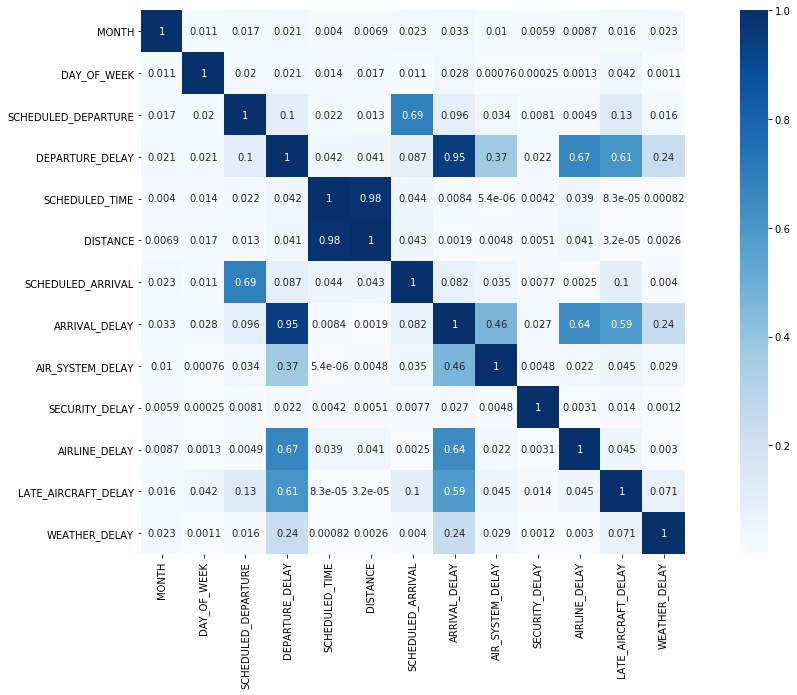

In [22]:
#Create a heatmap which shows correlation
corr = df.corr().abs()
plt.figure(figsize=(20,10))
ax = sns.heatmap(corr, annot=True, fmt='.2g', square=True, cmap= 'Blues') 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [23]:
#Investigate which features are correlated with the target variable 
df.corr()['DEPARTURE_DELAY']

MONTH                 -0.020631
DAY_OF_WEEK           -0.020872
SCHEDULED_DEPARTURE    0.102755
DEPARTURE_DELAY        1.000000
SCHEDULED_TIME         0.041651
DISTANCE               0.041254
SCHEDULED_ARRIVAL      0.086786
ARRIVAL_DELAY          0.948479
AIR_SYSTEM_DELAY       0.369213
SECURITY_DELAY         0.022429
AIRLINE_DELAY          0.668503
LATE_AIRCRAFT_DELAY    0.611428
WEATHER_DELAY          0.236239
Name: DEPARTURE_DELAY, dtype: float64

Unsurprisingly, we see that ARRIVAL_DELAY has the strongest correlation with departure delay. Additionally, AIRLINE_DELAY, and LATE_AIRCRAFT_DELAY have higher correlations with a delayed flight compared to other similar predictors.

In [24]:
#Convert all categorical variables to string types 
category = ['AIRLINE_CODE', 'ORIGIN_AIRPORT_CODE', 'DESTINATION_AIRPORT_CODE',
           'AIRPORT_CODE', 'CITY', 'STATE', 'COUNTRY', 'AIRLINE', 
            'ORIGIN_AIRPORT_TYPE', 'DESTINATION_AIRPORT_TYPE',]
df[category]=df[category].astype('str')

In [25]:
#Convert all continuous variables to float types 
floats = ['MONTH', 'DAY_OF_WEEK', 'SCHEDULED_DEPARTURE', 'SCHEDULED_TIME',
       'DISTANCE', 'SCHEDULED_ARRIVAL', 'ARRIVAL_DELAY', 'AIR_SYSTEM_DELAY',
       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
       'WEATHER_DELAY', 'DEPARTURE_DELAY']
df[floats]=df[floats].astype('int')

(txt about ohe)

In [26]:
#Need to OHE airline, origin airport, destination_airport, day of week 

df_new = pd.get_dummies(df, columns=['AIRLINE', 'ORIGIN_AIRPORT_TYPE', 'DESTINATION_AIRPORT_TYPE',
                                     'DAY_OF_WEEK', 'MONTH'], dtype='float')
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 59 columns):
AIRLINE_CODE                            10000 non-null object
ORIGIN_AIRPORT_CODE                     10000 non-null object
DESTINATION_AIRPORT_CODE                10000 non-null object
SCHEDULED_DEPARTURE                     10000 non-null int64
DEPARTURE_DELAY                         10000 non-null int64
SCHEDULED_TIME                          10000 non-null int64
DISTANCE                                10000 non-null int64
SCHEDULED_ARRIVAL                       10000 non-null int64
ARRIVAL_DELAY                           10000 non-null int64
AIR_SYSTEM_DELAY                        10000 non-null int64
SECURITY_DELAY                          10000 non-null int64
AIRLINE_DELAY                           10000 non-null int64
LATE_AIRCRAFT_DELAY                     10000 non-null int64
WEATHER_DELAY                           10000 non-null int64
AIRPORT_CODE                       

In [27]:
# We now have dummy variables that include the information on origin and destination airports, based on their 
# flight traffic, and as a result we can remove the other variables as their context and 
# #value is now embedded in our new varaible 
df_new = df_new.drop(['AIRLINE_CODE', 'AIRPORT_CODE', 'ORIGIN_AIRPORT_CODE', 'DESTINATION_AIRPORT_CODE',
                      'CITY', 'STATE', 'COUNTRY'], axis=1)

In [28]:
#Preview datatypes of all the features in the dataset
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 52 columns):
SCHEDULED_DEPARTURE                     10000 non-null int64
DEPARTURE_DELAY                         10000 non-null int64
SCHEDULED_TIME                          10000 non-null int64
DISTANCE                                10000 non-null int64
SCHEDULED_ARRIVAL                       10000 non-null int64
ARRIVAL_DELAY                           10000 non-null int64
AIR_SYSTEM_DELAY                        10000 non-null int64
SECURITY_DELAY                          10000 non-null int64
AIRLINE_DELAY                           10000 non-null int64
LATE_AIRCRAFT_DELAY                     10000 non-null int64
WEATHER_DELAY                           10000 non-null int64
AIRLINE_Alaska Airlines Inc.            10000 non-null float64
AIRLINE_American Airlines Inc.          10000 non-null float64
AIRLINE_American Eagle Airlines Inc.    10000 non-null float64
AIRLINE_Atlantic Southeast Airli

The final step in the data cleaning process is to transform the target variable from a continuous to a binary variable. If the departure delay time is greater than 0, then the filght will be classified as delayed.

In [29]:
#Transform continuous target variable to binary variable
#Variable will have value of 1 if departure was delayed, 0 otherwise 
df_new['DELAYED'] = df_new['DEPARTURE_DELAY'] > 0
df_new = df_new.drop(['DEPARTURE_DELAY'], axis=1)
df_new['DELAYED'] = df_new['DELAYED'].astype(int)  
df_new['DELAYED'].value_counts()

0    6384
1    3616
Name: DELAYED, dtype: int64

We see there is a bit of a class imbalance in our dataset. For now we will export this data to a new CSV file to proceed with the modelling process.

In [30]:
#Export final cleaned data to csv file 
df_new.to_csv('final_data.csv')